In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 1000
activation = 'relu'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 6)


In [25]:
X_train_scaled_df.shape

(15929, 6)

In [26]:
X_test_scaled_df.shape

(3983, 6)

In [27]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 2s 5ms/step - loss: 358.5871 - val_loss: 10.85041
Epoch 2/1000
498/498 [==============================] - 2s 4ms/step - loss: 2.6274 - val_loss: 0.9160
Epoch 3/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.6508 - val_loss: 0.5437
Epoch 4/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.3948 - val_loss: 0.3702.39
Epoch 5/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.2555 - val_loss: 0.3440
Epoch 6/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.1791 - val_loss: 0.2361- ETA: 0s - loss: 0.
Epoch 7/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.1318 - val_loss: 0.2230
Epoch 8/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0880 - val_loss: 0.2029
Epoch 9/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0650 - val_loss: 0.2417
Epoch 10/1000
498/498 [==============================] 

498/498 [==============================] - 2s 4ms/step - loss: 0.0107 - val_loss: 0.1288
Epoch 78/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0153 - val_loss: 0.1338
Epoch 79/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0104 - val_loss: 0.1361
Epoch 80/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0253 - val_loss: 0.1300A: 1s - lo - ETA: 0s 
Epoch 81/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0095 - val_loss: 0.1265- loss:  - ETA: 0s - loss: 0
Epoch 82/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0274 - val_loss: 0.1307 - loss
Epoch 83/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0118 - val_loss: 0.1314
Epoch 84/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0112 - val_loss: 0.1351
Epoch 85/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0103 - val_loss: 0.1267A: 1s - loss: 0. - ETA: 0s - - E

498/498 [==============================] - 2s 4ms/step - loss: 0.0080 - val_loss: 0.1119- ETA: 
Epoch 153/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0091 - val_loss: 0.1058ETA: 0s - los
Epoch 154/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0088 - val_loss: 0.1047
Epoch 155/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0153 - val_loss: 0.1050
Epoch 156/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0170 - val_loss: 0.1008
Epoch 157/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0097 - val_loss: 0.1056
Epoch 158/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0060 - val_loss: 0.0986
Epoch 159/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0132 - val_loss: 0.0992: 0s - loss: 0
Epoch 160/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0072 - val_loss: 0.1157
Epoch 161/1000
498/498 [=====================

498/498 [==============================] - 2s 4ms/step - loss: 0.0119 - val_loss: 0.0655
Epoch 228/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0648
Epoch 229/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0078 - val_loss: 0.0658
Epoch 230/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0055 - val_loss: 0.0636ss: 0.
Epoch 231/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0726
Epoch 232/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0098 - val_loss: 0.0823
Epoch 233/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0095 - val_loss: 0.0628
Epoch 234/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0099 - val_loss: 0.0620 0.
Epoch 235/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 0.0603
Epoch 236/1000
498/498 [==============================] - 2s 4ms/step 

498/498 [==============================] - 2s 4ms/step - loss: 0.0069 - val_loss: 0.0430ETA: 0s - 
Epoch 302/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0112 - val_loss: 0.0391
Epoch 303/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0366
Epoch 304/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0069 - val_loss: 0.0363
Epoch 305/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0105 - val_loss: 0.0361
Epoch 306/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0067 - val_loss: 0.0537
Epoch 307/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0370
Epoch 308/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0104 - val_loss: 0.0405
Epoch 309/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.03510s - 
Epoch 310/1000
498/498 [==============================] - 2s 4ms

498/498 [==============================] - 2s 4ms/step - loss: 0.0068 - val_loss: 0.0228
Epoch 376/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0076 - val_loss: 0.0301
Epoch 377/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0217- E
Epoch 378/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0185
Epoch 379/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0132 - val_loss: 0.0249
Epoch 380/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0190ETA: 0s - loss - ETA: 0s - loss:
Epoch 381/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0060 - val_loss: 0.0411
Epoch 382/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0059 - val_loss: 0.0240s -
Epoch 383/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0081 - val_loss: 0.0286 - loss: 0.0 - ETA: 0s -
Epoch 384/1000
49

498/498 [==============================] - 2s 4ms/step - loss: 0.0148 - val_loss: 0.0139ETA - ETA: 0s - loss: 0
Epoch 450/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0033 - val_loss: 0.0121A: 0s - l - ETA: 0s - loss:
Epoch 451/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0108 - val_loss: 0.0143
Epoch 452/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0160
Epoch 453/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0062 - val_loss: 0.0124
Epoch 454/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0119
Epoch 455/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 456/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0214
Epoch 457/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0128
Epoch 458/1000
498/498 [=====

498/498 [==============================] - 2s 4ms/step - loss: 0.0030 - val_loss: 0.0320TA: 0s - lo
Epoch 526/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 527/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 528/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 529/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0068A: 
Epoch 530/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0087
Epoch 531/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0175 - val_loss: 0.0064
Epoch 532/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 533/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0134
Epoch 534/1000
498/498 [==============================] - 2s 4ms/

Epoch 602/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0068 - val_loss: 0.0051 0s -
Epoch 603/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0037 - val_loss: 0.0118
Epoch 604/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 605/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0091 - val_loss: 0.0201
Epoch 606/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0063
Epoch 607/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 608/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0041 - val_loss: 0.0083
Epoch 609/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0064 - val_loss: 0.0052 - loss: 0.00 - ETA: 0s -
Epoch 610/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0104
Epoch 611/1000
498/498 [==========

498/498 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0069 1s - loss: 0 - ETA: 0
Epoch 676/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0095 - val_loss: 0.0044
Epoch 677/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0023 - val_loss: 0.0062 - 
Epoch 678/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0044TA: 
Epoch 679/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0059 - val_loss: 0.0061loss: 0.00 - ETA: 0s 
Epoch 680/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 681/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 682/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 683/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0091
Epoch 684/1000
498/498 [=====

498/498 [==============================] - 3s 7ms/step - loss: 0.0039 - val_loss: 0.0040ETA: 0s - loss: 0
Epoch 750/1000
498/498 [==============================] - 3s 6ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 751/1000
498/498 [==============================] - 3s 5ms/step - loss: 0.0039 - val_loss: 0.0045
Epoch 752/1000
498/498 [==============================] - 3s 5ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 753/1000
498/498 [==============================] - 3s 5ms/step - loss: 0.0038 - val_loss: 0.0030- ETA: 0s - loss: 
Epoch 754/1000
498/498 [==============================] - 3s 6ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 755/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0034 - val_loss: 0.0029
Epoch 756/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 757/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 758/1000
498/498 [====================

498/498 [==============================] - 2s 5ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 824/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 825/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 826/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0051 ETA: 0s - - ETA: 0s - loss: 
Epoch 827/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0065 - val_loss: 0.0028
Epoch 828/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 829/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0060 loss:
Epoch 830/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0054
Epoch 831/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0058 - val_loss: 0.0054
Epoch 832/1000
498/498 [====================

498/498 [==============================] - 2s 4ms/step - loss: 0.0041 - val_loss: 0.0029ETA: 0s - loss: 0.005 - ETA: 0s -
Epoch 899/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0034 - val_loss: 0.0035s  - ETA: 0s - loss: 0.
Epoch 900/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0060 - val_loss: 0.0030 - lo
Epoch 901/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0022 - val_loss: 0.0035
Epoch 902/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0031
Epoch 903/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0036s - loss: 0.0 - ETA: 0s - loss: 0.004
Epoch 904/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0038 - val_loss: 0.0099
Epoch 905/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0038ETA: 0s - loss: 0.
Epoch 906/1000
498/498 [==============================] - 2s 4ms/st

498/498 [==============================] - 2s 4ms/step - loss: 0.0073 - val_loss: 0.0031
Epoch 974/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0085 
Epoch 975/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 976/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0039 - val_loss: 0.00570s - loss:  - ETA: 0s - loss: 0.00
Epoch 977/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 978/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 979/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 980/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 981/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 982/1000
498/498 [====================

In [28]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 2s 5ms/step - loss: 8.8609 - val_loss: 0.0870: 0s - loss: 9.7
Epoch 2/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0493 - val_loss: 0.0305
Epoch 3/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0271 - val_loss: 0.0213
Epoch 4/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0201 - val_loss: 0.0155
Epoch 5/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0138 - val_loss: 0.0320TA: 0s - los - ETA: 0s - loss: 0
Epoch 6/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 7/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0117 - val_loss: 0.0147
Epoch 8/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0108 - val_loss: 0.0230
Epoch 9/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0115 - val_loss: 0.0337 ETA: 0s - loss: 0.011 - ETA: 0s - 

498/498 [==============================] - 2s 4ms/step - loss: 0.0075 - val_loss: 0.0166
Epoch 77/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0064 - val_loss: 0.0106
Epoch 78/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0077 - val_loss: 0.0151
Epoch 79/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0067 - val_loss: 0.0109 1s - loss: - ETA: 0s - l - ETA: 0s - loss: 0.00 - ETA: 0s - loss: 0.006
Epoch 80/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0066 - val_loss: 0.0112
Epoch 81/1000
498/498 [==============================] - 3s 6ms/step - loss: 0.0079 - val_loss: 0.0108 ETA
Epoch 82/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 83/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 84/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0071 - val_loss: 0.0181
Epoch 85/10

498/498 [==============================] - 2s 4ms/step - loss: 0.0066 - val_loss: 0.0229
Epoch 152/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0167
Epoch 153/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0069 - val_loss: 0.0150
Epoch 154/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0059 - val_loss: 0.0121A: 0s - loss: 0
Epoch 155/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0062 - val_loss: 0.0126
Epoch 156/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0186
Epoch 157/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0143
Epoch 158/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0058 - val_loss: 0.0137
Epoch 159/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0170
Epoch 160/1000
498/498 [==============================] - 2s 4ms

498/498 [==============================] - 2s 4ms/step - loss: 0.0058 - val_loss: 0.0109
Epoch 227/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0132
Epoch 228/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0051 - val_loss: 0.0150
Epoch 229/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 230/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0114
Epoch 231/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0061 - val_loss: 0.0100 loss: 0.00
Epoch 232/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0098
Epoch 233/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0098
Epoch 234/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0056 - val_loss: 0.0115
Epoch 235/1000
498/498 [==============================] - 2s 4ms/ste

Epoch 302/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 303/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0073oss: 
Epoch 304/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0072
Epoch 305/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0096
Epoch 306/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0124
Epoch 307/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0054 - val_loss: 0.0071
Epoch 308/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0090
Epoch 309/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0053 - val_loss: 0.0104
Epoch 310/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0056 - val_loss: 0.0097
Epoch 311/1000
498/498 [==============================] - 2

498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0058TA: 0s - loss: 
Epoch 378/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0058
Epoch 379/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0057 - val_loss: 0.0063A: 0s - loss: 0.0
Epoch 380/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 381/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 382/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0058 ETA: 1s - loss: 0.00 - ETA: 0s - - ETA: 0s - loss:
Epoch 383/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0052 - val_loss: 0.0062
Epoch 384/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 385/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0

498/498 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0095 0s - loss: 
Epoch 453/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0051 - val_loss: 0.0069 
Epoch 454/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 455/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0073A: 0s - loss: 0.003 - ETA: 0s - loss: 0.0
Epoch 456/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0050 - val_loss: 0.00500 - ETA: 0s - loss: 
Epoch 457/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 458/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 459/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0052
Epoch 460/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0083 - ETA

498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0053
Epoch 528/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 529/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 530/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 531/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 532/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0124s
Epoch 533/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 534/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 535/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0063ETA: 1s - - ETA: 0s - lo
Epoch 536/1000
498/498 [==============================

498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 603/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0046 ETA: 1s - ETA: 0s - loss
Epoch 604/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 605/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 606/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 607/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 608/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 609/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0041
Epoch 610/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 611/1000
498/498 [==============================

498/498 [==============================] - 2s 5ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 677/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0131
Epoch 678/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 679/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0041TA: 0s - 
Epoch 680/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 681/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 682/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 683/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 684/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 685/1000
498/498 [==============================] - 2s 4ms/step 

498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 752/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0046loss: 0
Epoch 753/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0044 - val_loss: 0.0038ss: 0 - ETA: 0s - loss: 0. - ETA: 0s - loss: 0.004 - ETA: 0s - loss: 0.00
Epoch 754/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0043 loss: 0.004
Epoch 755/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0094
Epoch 756/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 757/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 758/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0047 - val_loss: 0.0056- ETA
Epoch 759/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 -

498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 827/1000
498/498 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 0.0061
Epoch 828/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0079
Epoch 829/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0039
Epoch 830/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 831/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 832/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.00720s - ETA: 0s - loss: 0.0
Epoch 833/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 834/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 835/1000
498/498 [==============================]

498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 902/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0033- ETA: 1s - loss: 0.00 - E
Epoch 903/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 904/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0037A: 
Epoch 905/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0065
Epoch 906/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 907/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 908/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0052- ETA: 1s - l - ETA: 0s - 
Epoch 909/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0050
Epoch 910/1000
498/498 [

498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0047s - loss: 0.00 - ETA: 0s - loss: 0 - ETA: 0s - loss: 0.0 - ETA: 0s - loss: 0.
Epoch 976/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 977/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 978/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 979/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 980/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 981/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0043 - val_loss: 0.0033
Epoch 982/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0041 - val_loss: 0.0034
Epoch 983/1000
498/498 [==============================] - 2s 4ms/step - loss: 0.0044 - val_loss: 0.0034
Ep

In [29]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.008798564901027732
Root Mean Squared Error (RMSE): 0.05730079407793801


In [30]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.06366497849545873
Root Mean Squared Error (RMSE): 0.08536157909553346


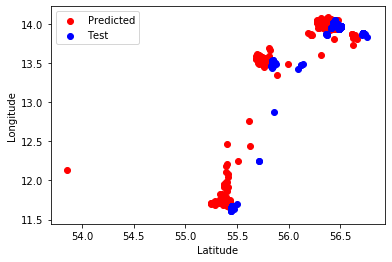

In [31]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='Test')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [32]:
X_test["population"].shape

(3983,)

In [33]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [34]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [35]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [36]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [37]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [38]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [39]:
combined_df = combined_df.dropna()

In [40]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.362812,13.989027,56.439716,13.991791
3,88.0,56.404812,13.992295,56.441143,13.988527
6,131.0,56.354439,13.986098,56.439716,13.992242
17,27.0,56.405079,13.994042,56.439903,13.992476
19,23.0,56.372128,13.993577,56.439484,13.992446
31,67.0,56.377441,13.995141,56.439350,13.992638
34,24.0,56.391945,13.997021,56.440166,13.992716
35,131.0,56.344101,13.987576,56.439930,13.992993
41,152.0,56.375114,13.990536,56.440140,13.992735
42,152.0,56.325020,14.013369,56.440044,13.992678


In [41]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [42]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.375114,13.990536,56.440140,13.992735
42,152.0,56.325020,14.013369,56.440044,13.992678
181,152.0,56.368755,13.998830,56.440220,13.992155
218,152.0,56.386238,13.985780,56.440342,13.992517
257,152.0,55.883236,13.355851,56.439884,13.991575
449,152.0,56.344357,13.954106,56.439644,13.992051
466,152.0,56.326294,13.997676,56.439968,13.992618
836,152.0,56.304035,14.005041,56.439949,13.992587
1010,152.0,56.341270,13.974071,56.439953,13.993013
1063,152.0,56.369522,13.984786,56.439720,13.992579


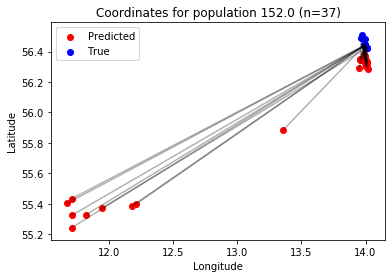

In [43]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [44]:
most_frequent_pop_df.shape

(37, 5)

In [45]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

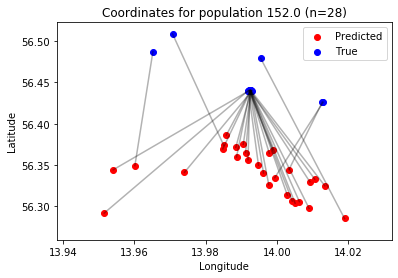

In [46]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [47]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

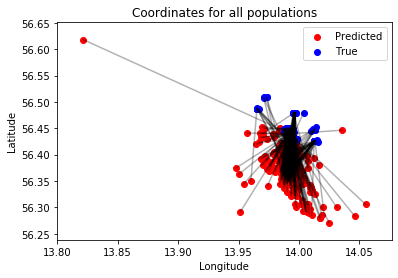

In [48]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()